In [26]:
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import pandas as pd
from torchvision.models import ResNet18_Weights
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import time
import copy
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader
from collections import Counter

In [13]:
# TRAINING SETTINGS
NUM_EPOCHS = 8


# LEARNING RATE SETTINGS
BASE_LR = 0.001
DECAY_WEIGHT = 0.1 # factor by which the learning rate is reduced.
EPOCH_DECAY = 30 # number of epochs after which the learning rate is decayed exponentially by DECAY_WEIGHT.


# DATASET INFO
NUM_LABELS = 8
DATA_DIR = '/shared/home/jea040/Final_Project/data'


# DATALOADER PROPERTIES
BATCH_SIZE = 32


# GPU SETTINGS
CUDA_DEVICE = 0 # Enter device ID of your gpu if you want to run on gpu. Otherwise neglect.
GPU_MODE = 1 # set to 1 if want to run on gpu.

Setup for NIH Dataset.

In [14]:
# Define the unified label set (including "Normal")
UNIFIED_LABELS = [
    "atelectasis", "cardiomegaly", "pleural effusion", "infiltration", 
    "nodule", "consolidation", "pleural thickening", "no finding"
]

# Define the mapping for "Finding Labels" to the unified labels
LABEL_MAP_NIH = {
    "atelectasis": 0,
    "cardiomegaly": 1,
    "effusion": 2,
    "infiltration": 3,
    "nodule": 4,
    "consolidation": 5,
    "pleural_thickening": 6,
    "no finding": 7
}

In [15]:
class NIHChestXrayDataset(Dataset):
    def __init__(self, images_dir, labels_csv, split_file=None, transform=None):
        self.images_dir = images_dir
        self.labels_df = pd.read_csv(labels_csv)
        self.split_file = split_file
        self.transform = transform
    
        # Filter CSV to match split list BEFORE generating label dict
        if self.split_file:
            with open(self.split_file, 'r') as f:
                keep_files = set(line.strip() for line in f.readlines())
            self.labels_df = self.labels_df[self.labels_df['Image Index'].isin(keep_files)]
    
        # Now build image label dict using the filtered DataFrame
        self.image_label_dict = self._get_image_labels()
        self.image_filenames = list(self.image_label_dict.keys())


    def _get_image_labels(self, max_no_finding=5000):
        image_label_dict = {}
        no_finding_count = 0
    
        for index, row in self.labels_df.iterrows():
            image_filename = row['Image Index']
            label_vector = torch.zeros(len(UNIFIED_LABELS))
            finding_labels = row['Finding Labels'].split('|')
            finding_labels = [label.strip().lower() for label in finding_labels]
    
            # Skip if none of the labels are in UNIFIED_LABELS
            valid_labels = [label for label in finding_labels if label in LABEL_MAP_NIH]
            if not valid_labels:
                continue
    
            # Check if it's a no finding image
            is_no_finding = (valid_labels == ['no finding'])
    
            if is_no_finding:
                if no_finding_count >= max_no_finding:
                    continue
                no_finding_count += 1
                label_vector[LABEL_MAP_NIH['no finding']] = 1
            else:
                for label in valid_labels:
                    label_vector[LABEL_MAP_NIH[label]] = 1
    
            image_label_dict[image_filename] = label_vector
    
        print(f"Total valid images (after downsampling): {len(image_label_dict)}")
        return image_label_dict

    
    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]
        
        # Construct the image path
        image_path = os.path.join(self.images_dir, image_filename)
        
        # Skip if the image does not exist
        if not os.path.exists(image_path):  # If image is missing
            return None  # Return None if image is missing
        
        try:
            image = Image.open(image_path).convert('RGB')  # Open image
        except Exception:
            return None  # Skip if image cannot be opened (e.g., corrupted)
        
        # Get the label vector for the image
        label_vector = self.image_label_dict.get(image_filename, torch.zeros(len(UNIFIED_LABELS)))
        
        # Apply transformations if available
        if self.transform:
            image = self.transform(image)
        
        return image, label_vector

In [39]:
# Define transformations for train and validation datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.485, 0.485], [0.229, 0.229, 0.229])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.485, 0.485], [0.229, 0.229, 0.229])
    ]),
}

# Paths to your datasets
nih_images_dir = '/shared/home/jea040/Final_Project/data/NIH_chestxrays/images'  # Path to NIH images
nih_labels_csv = '/shared/home/jea040/Final_Project/data/NIH_chestxrays/Data_Entry_2017.csv'  # NIH CSV file

# Dataset instances
nih_train_dataset = NIHChestXrayDataset(images_dir=nih_images_dir, labels_csv=nih_labels_csv, transform=data_transforms['train'])
nih_val_dataset = NIHChestXrayDataset(images_dir=nih_images_dir, labels_csv=nih_labels_csv, transform=data_transforms['val'])

Total valid images (after downsampling): 48877
Total valid images (after downsampling): 48877


Setup for PadChest dataset.

In [17]:
# Define the unified label set (including "Normal")
UNIFIED_LABELS_pad = [
    "atelectasis", "cardiomegaly", "pleural effusion", "infiltration", 
    "nodule", "consolidation", "pleural thickening", "Normal"
]

# Define the mapping for "Finding Labels" to the unified labels
LABEL_MAP_pad = {
    "atelectasis": 0,
    "cardiomegaly": 1,
    "pleural effusion": 2,
    "infiltrates": 3,
    "nodule": 4,
    "consolidation": 5,
    "apical pleural thickening": 6,
    "pleural thickening": 6,
    "normal": 7
}

In [18]:
class PadChestDataset(Dataset):
    def __init__(self, images_dir, labels_csv, transform=None, max_normal=5000):
        self.images_dir = images_dir
        self.labels_df = pd.read_csv(labels_csv)
        self.transform = transform
        self.max_normal = max_normal
        
        # Map image filenames to labels (multi-labels as binary vectors)
        self.image_label_dict = self._get_image_labels()
        self.image_filenames = list(self.image_label_dict.keys())

    def _get_image_labels(self):
        image_label_dict = {}
        normal_count = 0

        for index, row in self.labels_df.iterrows():
            image_filename = row['ImageID']  # column with image name
            label_vector = torch.zeros(len(UNIFIED_LABELS_pad))
            finding_labels = row['label'].split('|')
            finding_labels = [label.strip().lower() for label in finding_labels]

            valid_labels = [label for label in finding_labels if label in LABEL_MAP_pad]

            # Skip if no valid labels
            if not valid_labels:
                continue

            # Check if this is a "Normal" image
            is_normal = (valid_labels == ['normal'])

            if is_normal:
                if normal_count >= self.max_normal:
                    continue
                normal_count += 1
                label_vector[LABEL_MAP_pad['normal']] = 1
            else:
                for label in valid_labels:
                    label_vector[LABEL_MAP_pad[label]] = 1

            image_label_dict[image_filename] = label_vector

        print(f"Total valid images (after downsampling): {len(image_label_dict)}")
        return image_label_dict

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]
        image_path = os.path.join(self.images_dir, image_filename)

        if not os.path.exists(image_path):
            return None
        
        try:
            image = Image.open(image_path).convert('RGB')
        except:
            return None
        
        label_vector = self.image_label_dict.get(image_filename, torch.zeros(len(UNIFIED_LABELS_pad)))
        
        if self.transform:
            image = self.transform(image)

        return image, label_vector


In [19]:
# Define transformations for train and validation datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.485, 0.485], [0.229, 0.229, 0.229])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.485, 0.485], [0.229, 0.229, 0.229])
    ]),
}

# Paths to your datasets
padchest_images_dir = '/shared/home/jea040/Final_Project/data/padchest/images/PadChest_GR'  # Path to PadChest images
padchest_labels_csv = '/shared/home/jea040/Final_Project/data/padchest/master_table.csv'  # PadChest CSV file

padchest_dataset = PadChestDataset(images_dir=padchest_images_dir, labels_csv=padchest_labels_csv, transform=data_transforms['val'])

Total valid images (after downsampling): 2519


In [30]:
def get_disease_names(label_tensor, label_names):
    return [label_names[i] for i, val in enumerate(label_tensor) if val == 1]

def show_image_with_labels(image_tensor, label_tensor, label_names, title="X-ray"):
    img_np = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * 0.229) + 0.485  # unnormalize
    img_np = np.clip(img_np, 0, 1)
    
    plt.imshow(img_np, cmap='gray')
    plt.axis('off')
    diseases = get_disease_names(label_tensor, label_names)
    plt.title(f"{title}\nLabels: {', '.join(diseases) if diseases else 'No findings'}")
    plt.show()

def predict(model, input_tensor):
    model.eval()
    with torch.no_grad():
        if input_tensor.ndim == 3:  # Only (C, H, W)
            input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension
        output = model(input_tensor.to(device))
        pred = (torch.sigmoid(output) > 0.5).int().cpu().squeeze()
    return pred


def demo_prediction(models_dict, image_tensor, label_tensor, label_names, title):
    print(f"\n📷 {title}")
    print("Ground Truth:", get_disease_names(label_tensor, label_names))
    show_image_with_labels(image_tensor, label_tensor, label_names, title)

    for name, model in models_dict.items():
        pred = predict(model, image_tensor.unsqueeze(0).to(device))
        pred_names = get_disease_names(pred, label_names)
        print(f"  {name} Prediction: {pred_names if pred_names else ['No findings']}")


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------- 1. Rebuild model architecture ----------
def build_resnet18_model(num_labels=NUM_LABELS):
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_labels)
    return model.to(device)

# --------- 2. Load all models from state_dicts ----------

model_paths = {
    "Non-Pretrained": '/shared/home/jea040/Final_Project/notebooks/nih_model.pt',
    "Pretrained": '/shared/home/jea040/Final_Project/notebooks/nih_model_pretrained.pt',
    "Pretrained + Scheduler": '/shared/home/jea040/Final_Project/notebooks/nih_model_pretrained_scheduled.pt',
    "FGSM-Finetuned": '/shared/home/jea040/Final_Project/notebooks/model_adv_fgsm_finetuned.pt',
    "BIM-Finetuned": '/shared/home/jea040/Final_Project/notebooks/model_adv_bim_finetuned.pt',
    "PGD-Finetuned": '/shared/home/jea040/Final_Project/notebooks/model_adv_pgd_finetuned.pt'
}

models_loaded = {}

for name, path in model_paths.items():
    model = build_resnet18_model(num_labels=NUM_LABELS)
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    models_loaded[name] = model

In [95]:
nih_train_tensor, nih_train_label = nih_train_dataset[200]
nih_img_tensor, nih_label = nih_val_dataset[200]
pad_img_tensor, pad_label = padchest_dataset[200]


📷 NIH Chest X-ray Train
Ground Truth: ['no finding']


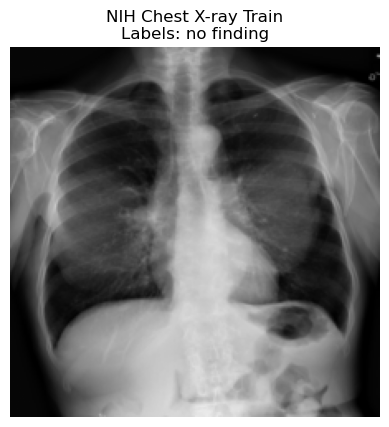

  Non-Pretrained Prediction: ['no finding']
  Pretrained Prediction: ['nodule', 'no finding']
  Pretrained + Scheduler Prediction: ['no finding']
  FGSM-Finetuned Prediction: ['nodule']
  BIM-Finetuned Prediction: ['no finding']
  PGD-Finetuned Prediction: ['no finding']

📷 NIH Chest X-ray Val
Ground Truth: ['no finding']


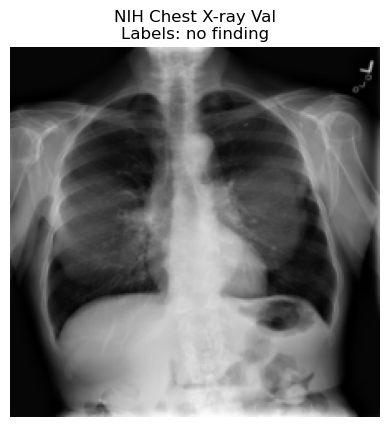

  Non-Pretrained Prediction: ['no finding']
  Pretrained Prediction: ['no finding']
  Pretrained + Scheduler Prediction: ['no finding']
  FGSM-Finetuned Prediction: ['no finding']
  BIM-Finetuned Prediction: ['no finding']
  PGD-Finetuned Prediction: ['no finding']

📷 PadChest X-ray
Ground Truth: ['no finding']


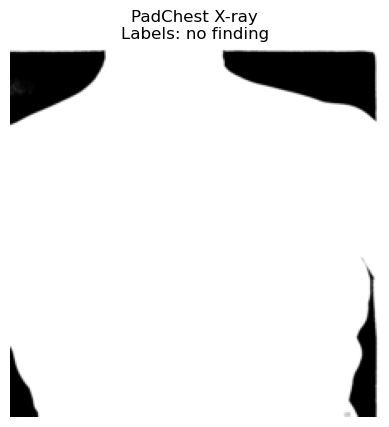

  Non-Pretrained Prediction: ['pleural effusion', 'consolidation']
  Pretrained Prediction: ['pleural effusion', 'nodule', 'consolidation']
  Pretrained + Scheduler Prediction: ['No findings']
  FGSM-Finetuned Prediction: ['infiltration']
  BIM-Finetuned Prediction: ['No findings']
  PGD-Finetuned Prediction: ['No findings']


In [96]:
demo_prediction(models_loaded, nih_train_tensor, nih_train_label, UNIFIED_LABELS, "NIH Chest X-ray Train")
demo_prediction(models_loaded, nih_img_tensor, nih_label, UNIFIED_LABELS, "NIH Chest X-ray Val")
demo_prediction(models_loaded, pad_img_tensor, pad_label, UNIFIED_LABELS, "PadChest X-ray")

In [97]:
nih_train_tensor, nih_train_label = nih_train_dataset[538]
nih_img_tensor, nih_label = nih_val_dataset[538]
pad_img_tensor, pad_label = padchest_dataset[538]


📷 NIH Chest X-ray Train
Ground Truth: ['no finding']


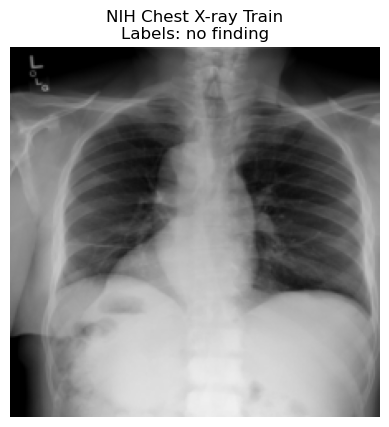

  Non-Pretrained Prediction: ['No findings']
  Pretrained Prediction: ['no finding']
  Pretrained + Scheduler Prediction: ['No findings']
  FGSM-Finetuned Prediction: ['No findings']
  BIM-Finetuned Prediction: ['no finding']
  PGD-Finetuned Prediction: ['infiltration']

📷 NIH Chest X-ray Val
Ground Truth: ['no finding']


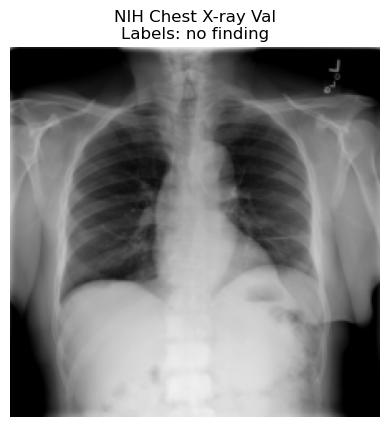

  Non-Pretrained Prediction: ['atelectasis']
  Pretrained Prediction: ['no finding']
  Pretrained + Scheduler Prediction: ['no finding']
  FGSM-Finetuned Prediction: ['no finding']
  BIM-Finetuned Prediction: ['no finding']
  PGD-Finetuned Prediction: ['no finding']

📷 PadChest X-ray
Ground Truth: ['no finding']


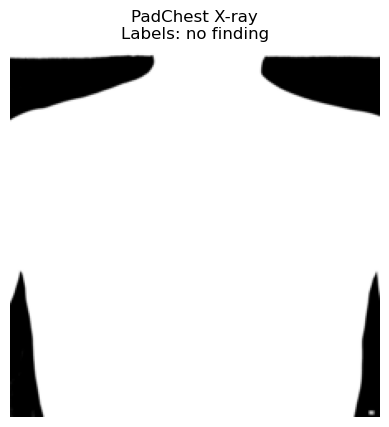

  Non-Pretrained Prediction: ['pleural effusion', 'consolidation']
  Pretrained Prediction: ['pleural effusion', 'consolidation']
  Pretrained + Scheduler Prediction: ['No findings']
  FGSM-Finetuned Prediction: ['infiltration']
  BIM-Finetuned Prediction: ['infiltration']
  PGD-Finetuned Prediction: ['No findings']


In [98]:
demo_prediction(models_loaded, nih_train_tensor, nih_train_label, UNIFIED_LABELS, "NIH Chest X-ray Train")
demo_prediction(models_loaded, nih_img_tensor, nih_label, UNIFIED_LABELS, "NIH Chest X-ray Val")
demo_prediction(models_loaded, pad_img_tensor, pad_label, UNIFIED_LABELS, "PadChest X-ray")